#  Overview: MCMC Diagnostics

## Adapted from the TALENT course on Learning from Data: Bayesian Methods and Machine Learning
### York, UK, June 10-28, 2019

The original notebook was by Christian Forssen.  Revisions are by Dick Furnstahl for Physics 8805.

In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import norm, uniform

import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set_style('white')
sbn.set_context('talk')

import pandas as pd
import warnings
warnings.filterwarnings('ignore')


## MCMC diagnostics: assessing convergence

From previous notebooks, we know that using Metropolis-Hastings (MH) leads to a Markov Chain that we can use for inference. This is predicated on our chain converging to our stationary distribution (the posterior).  Knowing when a chain has converged is a numerical issue and there are some diagnostic tools that we can use for assessing convergence.

#### BDA3: Gelman et al, Fig. 11.1
![BDA3: Gelman et al, Fig. 11.1](gelman_11.1.png)

### Fitting a straight line - revisited
Let us revisit the problem of inferring the parameters of a straight line. See also [parameter_estimation_fitting_straight_line_I.ipynb](../bayesian-parameter-estimation/parameter_estimation_fitting_straight_line_I.ipynb) and [parameter_estimation_fitting_straight_line_II.ipynb](../why-bayes-is-better/parameter_estimation_fitting_straight_line_II.ipynb)

#### The Data

Let's start by creating some data that we will fit with a straight line.  We'll start with a constant standard deviation of $\sigma$ on the $y$ values and no error on $x$.

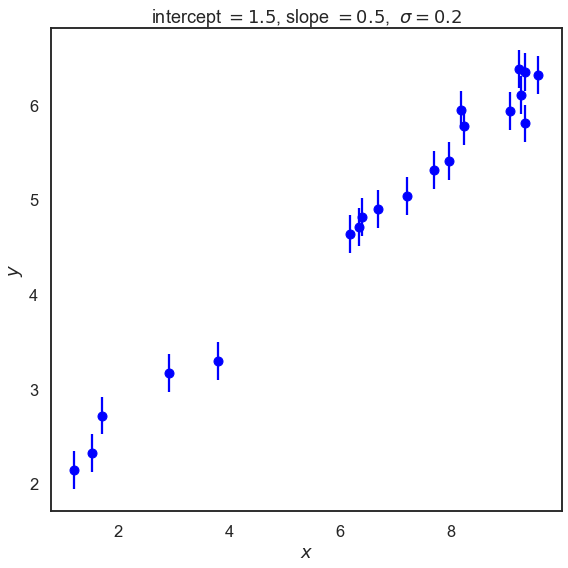

In [2]:
np.random.seed()   # set up the random seed for later calls

def make_data(intercept, slope, N_pts=20, dy=.2, rseed=None):
    """Given a straight line defined by intercept and slope:
          y = slope * x + intercept
       generate N_pts points randomly spaced points from x=0 to x=x_max
       with Gaussian (i.e., normal) error with mean zero and standard
       deviation dy.
       
       Unless rseed is specified as an integer, new random data will be 
       generated each time.
       
       Return the x and y arrays and an array of standard deviations.
    """
    rand = np.random.RandomState(rseed) 
    
    x_max = 10.
    x = x_max * rand.rand(N_pts)  # choose the x values randomly in [0,10]
    y = intercept + slope * x  # This is the y value without noise
    y += dy * rand.randn(N_pts)    # Add in Gaussian noise
    return x, y, dy * np.ones_like(x)  # return coordinates and error bars

# Specify the true parameters and make sample data
intercept = 1.5   # true intercept (called b elsewhere)
slope = 0.5       # true slope (called m elsewhere)
theta_true = [intercept, slope]  # put parameters in a true theta vector
x, y, dy = make_data(*theta_true)

# Make a plot of the data
fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(x, y, dy, fmt='o', color='blue')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plot_title = rf'intercept $= {intercept:.1f}$, slope $= {slope:.1f}$, ' \
              + rf' $\sigma = {dy[0]:.1f}$'
ax.set_title(plot_title)
fig.tight_layout()

#### The Model

Next we need to specify a theoretical model. We're fitting a straight line to data, so we'll need a slope and an intercept; i.e.

$$
y_{\textrm{th}}(x) = mx + b
$$

where our parameter vector will be 

$$
\theta = [b, m]
$$

But this is only half the picture: what we mean by a "model" in a Bayesian sense is not only this expected value $y_{\textrm{th}}(x;\theta)$, but a **probability distribution** for our data.
That is, we need an expression to compute the likelihood $p(D\mid\theta, I)$ for our data as a function of the parameters $\theta$ ($I$ stands for all other information).
Here $D$ is the set of all $(x,y)$ pairs that we know about (or measure).

\[Note: At this stage we are (implicitly) assuming that our theoretical model is perfect.  But it is not!  We'll come back eventually to talk about adding a theory error $\delta y_{\textrm{th}}$.\]

We are given data with simple error bars, which imply that the probability for any *single* data point (labeled by $i$) is a normal distribution with mean given by the true value. That is,

$$
y_i \sim \mathcal{N}(y_{\textrm{th}}(x_i;\theta), \varepsilon_i^2)
$$

or, in other words,

$$
p(y_i\mid x_i,\theta,  I) = \frac{1}{\sqrt{2\pi\varepsilon_i^2}} \exp\left(\frac{-\left[y_i - y_{\textrm{th}}(x_i;\theta)\right]^2}{2\varepsilon_i^2}\right)
$$

where $\varepsilon_i$ are the (known) measurement errors indicated by the error bars.

Assuming all the points are independent, we can find the full likelihood by multiplying the individual likelihoods together:

$$
p(D\mid\theta, I) = \prod_{i=1}^N p(y_i\mid x_i,\theta, I)
$$

For convenience (and also for numerical accuracy) this is often expressed in terms of the log-likelihood:

$$
\log p(D\mid\theta, I) = -\frac{1}{2}\sum_{i=1}^N\left(\log(2\pi\varepsilon_i^2) + \frac{\left[y_i - y_M(x_i;\theta)\right]^2}{\varepsilon_i^2}\right)
$$

In [3]:
# Log likelihood
def log_likelihood(theta, x, y, dy):
    """Return the log likelihood given the vector of parameters theta and
        numpy arrays for x, y, and dy (which is the standard deviation).
    """
    y_model = theta[0] + theta[1] * x
    return -0.5 * np.sum(np.log(2 * np.pi * dy ** 2) + 
                         (y - y_model) ** 2 / dy ** 2)

# Let's use the (log) symmetric prior, which is the scale-invariant one.
# Uniform prior for the offset
def log_prior(theta):
    """Prior p(m) proportional to (1 + m^2)^{-3/2}"""
    if np.abs(theta[0]) < 1000:
        return -1.5 * np.log(1 + theta[1]**2)
    else:
        return -np.inf  # log(0)
    
def log_posterior(theta, x, y, dy):
    """Return the log posterior by evaluating the log prior and log
        likelihood.
       Probably should first check if the log prior is -np.inf before 
        evaluating the log likelihood
    """
    return log_prior(theta) + log_likelihood(theta, x, y, dy)

We will use the emcee sampler, but in its Metropolis-Hastings mode. Here you can use your own sampler if you created one.

In [4]:
import emcee
import corner
print('emcee sampling (version: )', emcee.__version__)

ndim = 2  # number of parameters in the model
nwarmup = 1000
nsteps = 5000

# MH-Sampler setup
stepsize = .002
cov = stepsize * np.eye(ndim)
p0 = np.random.rand(ndim)

# initialize the sampler
sampler = emcee.MHSampler(cov, ndim, log_posterior, args=[x, y, dy])

emcee sampling (version: ) 2.2.1


Performing 1000 warnup iterations.
MH sampler performing 5000 samples.
CPU times: user 1.11 s, sys: 20.4 ms, total: 1.13 s
Wall time: 1.11 s
done
Mean acceptance fraction: 0.164


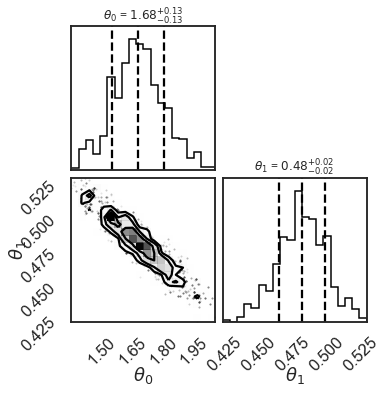

In [5]:
# Sample the posterior distribution

# Warm-up
if nwarmup > 0:
    print(f'Performing {nwarmup} warnup iterations.')
    pos, prob, state = sampler.run_mcmc(p0, nwarmup)
    sampler.reset()
else:
    pos = p0
    
# Perform iterations, starting at the final position from the warmup.
print(f'MH sampler performing {nsteps} samples.')
%time sampler.run_mcmc(pos, nsteps)
print("done")

print(f"Mean acceptance fraction: {sampler.acceptance_fraction:.3f}")

samples = sampler.flatchain
samples_unflattened = sampler.chain
lnposts = sampler.lnprobability
    
# make a corner plot with the posterior distribution
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], labels=[r"$\theta_0$", r"$\theta_1$"],
                       show_titles=True, title_kwargs={"fontsize": 12})

In [6]:
samples.shape
samples_unflattened.shape

(5000, 2)

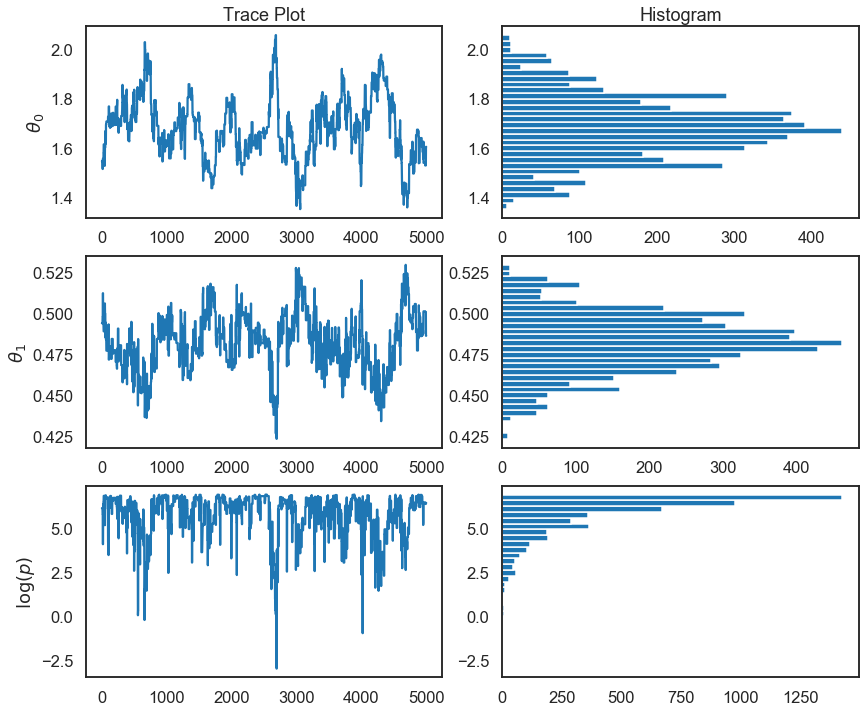

In [7]:
fix, ax = plt.subplots(3,2,figsize=(12,5*ndim))
for irow in range(ndim):
    ax[irow,0].plot(np.arange(samples.shape[0]),samples[:,irow])
    ax[irow,0].set_ylabel(r'$\theta_{0}$'.format(irow))
    ax[irow,1].hist(samples[:,irow],orientation='horizontal',bins=30)
    
ax[2,0].plot(np.arange(samples.shape[0]),lnposts)
ax[2,1].hist(lnposts,orientation='horizontal',bins=30)
ax[2,0].set_ylabel(r'$\log(p)$')

ax[0,1].set_title('Histogram')
ax[0,0].set_title('Trace Plot')

plt.tight_layout()

## How do we know this chain has converged to the posterior?
Credit to [BDA3](http://www.stat.columbia.edu/~gelman/book/) by Gelman et al. and lecture notes by [Rob Hicks](https://rlhick.people.wm.edu/)

### Standard Error of the Mean

This investigates the question how does the **mean** of $\theta$ deviate in our chain, and is capturing the *simulation error* of the mean rather than underlying uncertainty of our parameter $\theta$:

$$
SE({\bar{\theta}}) = \frac{\text{Posterior Standard Deviation}}{\sqrt{N}}
$$

where $N$ is the chain length (the number of iterations in your chain). 

For our problem this is:

In [8]:
for irow in range(ndim):
    print(f"Standard Error of the Mean for theta_{irow}: {samples[:,irow].std()/np.sqrt(samples.shape[0]):.1e}")

Standard Error of the Mean for theta_0: 1.8e-03
Standard Error of the Mean for theta_1: 2.5e-04


This is saying that very little of our posterior variation in $\theta$ is due to sampling error (that is good).  We can visualize this by examining the moving average of our chain as we move through the iterations:

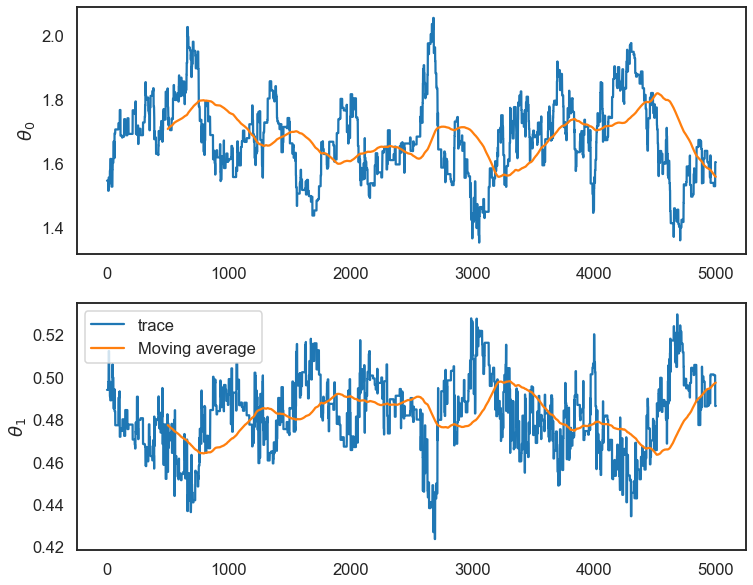

In [9]:
fix, ax = plt.subplots(2,1,figsize=(12,10))
# pandas makes this easy:
df_chain = pd.DataFrame(samples,columns=['theta0','theta1'])
df_chain['ma_theta0'] = df_chain.theta0.rolling(window=500,center=False).mean()
df_chain['ma_theta1'] = df_chain.theta1.rolling(window=500,center=False).mean()

ax[0].plot(np.arange(samples.shape[0]),samples[:,0],label=r'$\theta_0$')
ax[0].plot(np.arange(samples.shape[0]),df_chain['ma_theta0'],label=r'Moving average')
ax[0].set_ylabel(r'$\theta_0$')

ax[1].plot(np.arange(samples.shape[0]),samples[:,1],label=r'trace')
ax[1].plot(np.arange(samples.shape[0]),df_chain['ma_theta1'],label=r'Moving average')
ax[1].set_ylabel(r'$\theta_1$')

plt.legend();

This is a good sign that our chain is stable, since both the individual samples of $\theta$ in our chain and the mean of the samples dance around a stable value of $\theta$.  The calculation above makes this more concrete.  There are time series versions of this calculation that accounts for the fact that the chain is not iid.

### Autocorrelation Plots

In [10]:
def autocorrelation(chain, max_lag=100):
    dimension = len(chain)
    acors = np.empty(max_lag+1)
    if max_lag > len(chain)/5:
        warnings.warn('max_lag is more than one fifth the chain length')
    # Create a copy of the chain with average zero
    chain1d = chain - np.average(chain)
    for lag in range(max_lag+1):
        unshifted = None
        shifted = chain1d[lag:]
        if 0 == lag:
            unshifted = chain1d
        else:
            unshifted = chain1d[:-lag]
        normalization = np.sqrt(np.dot(unshifted, unshifted))
        normalization *= np.sqrt(np.dot(shifted, shifted))
        acors[lag] = np.dot(unshifted, shifted) / normalization
    return acors

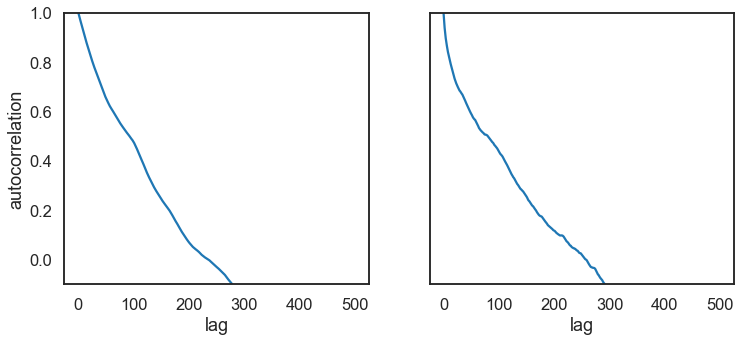

In [11]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(12,5))
for icol in range(ndim):
    acors = autocorrelation(samples[:,icol],max_lag=500)
    ax[icol].plot(acors)
    ax[icol].set_xlabel('lag')
ax[0].set(ylabel='autocorrelation', ylim=(-.1, 1));

### Acceptance Rate for the MH Algorithm

Recall that we want the acceptance rate to be in the range .2 to .4.  For our problem [this paper](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.aoap/1034625254) suggests an acceptance rate of .234 for random walk MH.

Since the number of **new** members in the chain represent the number of acceptances, count changes in chain values and divide by total chain length to calculate acceptance rate:

In [12]:
print(f"Acceptance Rate is: {sampler.acceptance_fraction:.3f}")

Acceptance Rate is: 0.164


The acceptance rate is helpful in describing convergence because it indicates a good level of "mixing" over the parameter space. The acceptance rate can be tuned via the proposal width after which we re-run our MH MCMC sampler.

> Note: modern software (like pymc and emcee) can auto-tune the proposal distribution to achieve a desired acceptance rate.

### Gelman Rubin Diagnostic

If our MH MCMC Chain reaches a stationary distribution, and we repeat the exercise multiple times, then we can examine if the posterior for each chain converges to the same place in the distribution of the parameter space.

Steps:
1. Run multiple chains starting at different points (multiple walkers).  Discard the warm-up for each.
2. Split each chain in two, with $N$ iterations in each half chain.  Call $M$ the total number of chains now (twice the original number). 
3. Calculate the within and between chain variance.  This tests both mixing (if well-mixed, the separate parts of different chains should mix) and stationarity (two halves of each chain should be sampling the same distribution).
    * Label the scalar parameter or expectation value being tested as $\psi$ and label the simulated results as $\psi_{ij}$, where $i$ runs from 1 to $N$ within each chain and $j$ labels the chain from 1 to $M$.  Then we define:
    $$
    \overline\psi_{\cdot j} \equiv \frac{1}{N} \sum_{i=1}^{N} \psi_{ij}
    \quad \mbox{and} \quad
    \overline\psi_{\cdot \cdot} \equiv \frac{1}{M} \sum_{j=1}^{M} \overline\psi_{\cdot j}    
    $$
    where $\overline\psi_{\cdot j}$ is the mean within chain $j$ and $\overline\psi_{\cdot \cdot}$ is the average (mean) of these means across the $M$ chains.
    
    * Within chain variance:
    $$
    W = \frac{1}{M}\sum_{j=1}^M s_j^2 
    \quad \mbox{where} \quad
    s_j^2 = \frac{1}{N-1}\sum_{i=1}^{N}(\psi_{ij} - \overline\psi_{\cdot j})^2 \;,
    $$
    with $s_j^2$ is the variance of each chain.  So $W$ is the mean of the in-chain variances.  It is expected that $W$ will *underestimate* the variance of $\psi$ (which we'll denote ${\mbox{var}}(\psi)$ because an individual sequence (i.e., chain) with $N < \infty$ will not have run forever, so it will not have ranged over the full target distribution, so it will have less variability.
    
    * Between chain variance:
    $$
    B = \frac{N}{M-1} \sum_{j=1}^M (\overline\psi_{\cdot j} - \overline\psi_{\cdot \cdot})^2 \;.
    $$
    There is an $N$ in the numerator of $B$ because it is from the variance of the within-sequence means $\overline\psi_{\cdot j}$,
    each of which is an average of $N$ values $\psi_{ij}$.
    
    4. Calculate the estimated variance of $\psi$ as the weighted sum of within and between chain variance.
    $$
    \hat{\mbox{var}}(\psi)^{+} = \left ( 1 - \frac{1}{N}\right ) W + \frac{1}{N}B  \;.
    $$
    This quantity is expected to *overestimate* ${\mbox{var}}(\psi)$ but is unbiased under stationarity.  

    5. Calculate the potential scale reduction factor, $\hat{R}$, which is the factor by which the scale that characterizes the distribution for $\psi$ at the current stage might be reduced if we increased each chain size $N$ toward infinity:
    $$
    \hat{R} = \sqrt{\frac{\hat{\mbox{var}}(\psi)}{W}}
    $$
Based on our expectations, this should be greater than 1 because the numerator overestimates ${\mbox{var}}(\psi)$ and denominator underestimates it.  But if it is close to 1, then it should mean that both chains are mixing around the stationary distribution.   
Gelman and Rubin show that when $\hat{R}$ is greater than 1.1 or 1.2, we need longer runs.

Let's run 2 chains:

In [13]:
no_of_chains=2
chains=[]

for ichain in range(no_of_chains):
    sampler.reset()
    p0 = np.random.rand(ndim)
    # Warm-up
    if nwarmup > 0:
        print(f'Chain {ichain} performing {nwarmup} warnup iterations.')
        pos, prob, state = sampler.run_mcmc(p0, nwarmup)
        sampler.reset()
    else:
        pos = p0
    
    # Perform iterations, starting at the final position from the warmup.
    print(f'MH sampler {ichain} performing {nsteps} samples.')
    sampler.run_mcmc(pos, nsteps)
    print("done")
    print(f"Mean acceptance fraction: {sampler.acceptance_fraction:.3f}")

    chains.append(sampler.flatchain)

Chain 0 performing 1000 warnup iterations.
MH sampler 0 performing 5000 samples.
done
Mean acceptance fraction: 0.154
Chain 1 performing 1000 warnup iterations.
MH sampler 1 performing 5000 samples.
done
Mean acceptance fraction: 0.163


In [14]:
chain1 = chains[0]
chain2 = chains[1]
num_iter = chain1.shape[0]

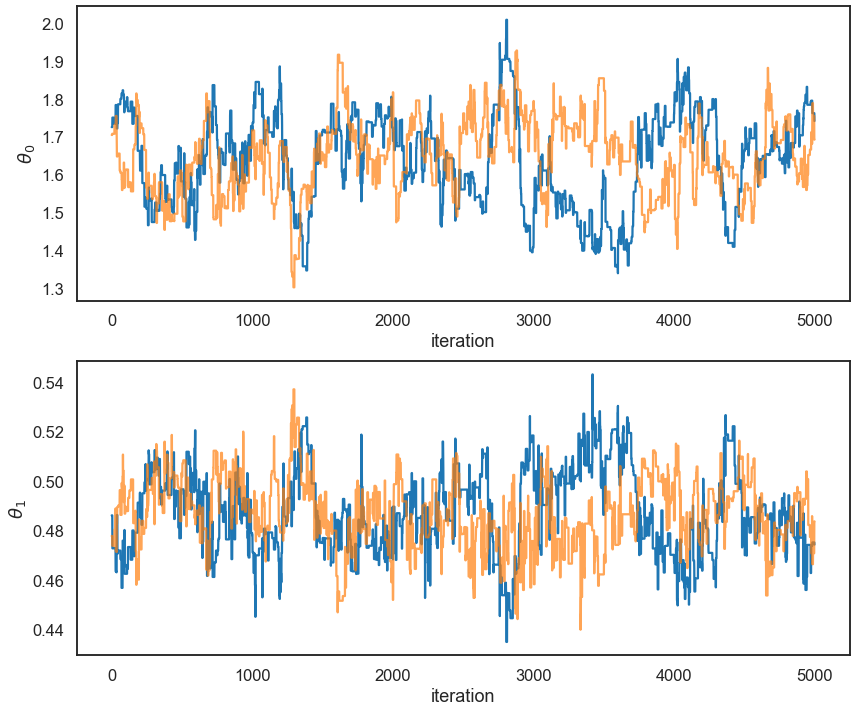

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12,10))
for icol in range(ndim):
    ax[icol].plot(np.arange(num_iter), chain1[:,icol])
    ax[icol].plot(np.arange(num_iter), chain2[:,icol], alpha=.7)
    ax[icol].set_ylabel(fr'$\theta_{icol}$')
    ax[icol].set_xlabel('iteration')
    
fig.tight_layout()

In [16]:
# rewrite of Gelman-Rubin estimation
# we only want one of the variables
Nchain = int(nsteps / 2)  # full chain

Nchain = 2500  # size of each chain to use here
Mchain = 4   # total number of chains
param = 0    # which parameter to use


def Gelman_Rubin_diagnostic_calc(chains, Nchain, Mchain=4, param=0):
    psi_chains = np.zeros((Mchain, Nchain))
    for icol in range(0, Mchain, 2):
        i = int(icol/2)
        psi_chains[icol,:] = np.array( chains[i] )[:Nchain, param]
        psi_chains[icol+1,:] = np.array( chains[i] )[Nchain:2*Nchain, param]
    
    psi_mean = np.array([chain.mean() for chain in psi_chains])
    psi_mean_all = psi_mean.sum() / Mchain

    var_chain = np.zeros(Mchain)
    for i in range(Mchain):
        var_chain[i] = 1./(Nchain - 1) * \
                           ((psi_chains[i] - psi_mean[i])**2).sum()

    W = var_chain.sum() / Mchain

    B = Nchain / (Mchain - 1) * \
          np.array([(mean - psi_mean_all)**2 for mean in psi_mean]).sum()
    
    var_theta = (1. - 1./Nchain) * W + 1./Nchain * B
    Rhat = np.sqrt(var_theta/W)
    print(fr"Nchain = {Nchain:4d}  Rhat = {Rhat:.3f}")
    
print(f"Gelman-Rubin Diagnostic for different chain lengths: ")
for Nchain in [50, 100, 200, 500, 1000, 2000]:
    Gelman_Rubin_diagnostic_calc(chains, Nchain, param=0)

Gelman-Rubin Diagnostic for different chain lengths: 
Nchain =   50  Rhat = 3.293
Nchain =  100  Rhat = 1.476
Nchain =  200  Rhat = 1.824
Nchain =  500  Rhat = 1.030
Nchain = 1000  Rhat = 1.047
Nchain = 2000  Rhat = 1.048


To repeat: Gelman and Rubin show that when $\hat{R}$ is greater than 1.1 or 1.2, we need longer runs.


# Univariate Approaches

The diagnostics we have discussed are all univariate (they work perfectly when there is only one parameter to estimate).  

So most people examine univariate diagnostics *for each variable*, examine autocorrelation plots, acceptance rates and try to argue chain convergence based on that.